## Analyzing outputs of 100 parameter sets ensemble simulaitons
Analyzing updated batch of ensemble simulations since 'sim_opt100.ipynb'. <br/>
Simulation outputs stored: /home/disk/eos8/ach315/upscale/sims/opt (previous outputs now moved to archive)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import xarray as xr
import datetime
import seaborn as sns
import pingouin as pg

# my functions
from funcs import fold
#from funcs import get_filelist # *** why this is not working?

### 1. Loading in parameter info

In [3]:
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params.head()

juv_leaves  stayGreen  rmax_ltir  phyllo  LM_min  Vcmax   Vpmax    g1  \
0          23       4.44       1.24    3.31   98.77  77.29   92.57  9.86   
1          16       7.13       0.55    3.98   89.85  67.10   87.81  1.37   
2          21       6.51       1.00    3.04   81.24  66.65   81.56  3.88   
3          24       4.67       0.68    3.24   97.70  69.56   69.67  4.86   
4          20       4.32       0.82    3.13  115.08  64.44  101.27  6.31   

   ref_potential  rmax_ltar  
0          -3.38       0.62  
1          -2.83       0.28  
2          -2.63       0.50  
3          -3.63       0.34  
4          -3.40       0.41

### 2. Reading in simulation outputs

In [2]:
def get_filelist(path):
    '''
    For the given path, get the List of all files in the directory tree
    including those in subdirectories
    '''
    # create a list of file and sub directories names in the given directory 
    filelist = os.scandir(path)
    allfiles = list()
    # iterate over all the entries
    for entry in filelist:
        # create full path
        fullpath = os.path.join(path, entry)
        # if entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullpath):
            allfiles = allfiles + get_filelist(fullpath)
        else:
            allfiles.append(fullpath)
    return allfiles

In [4]:
%%time

# fetching all simulation outputs
#filelist = get_filelist('/home/disk/eos8/ach315/upscale/sims/opt/')
filelist = get_filelist('/home/disk/eos8/ach315/upscale/sims/opt/1961')

# manual update of maizsim output column name
cols = ['year', 'cvar', 'site',
        'date', 'jday', 'time', 
        'leaves', 'mature_lvs', 'drop_lvs', 'LA', 'LA_dead', 'LAI', 
        'RH', 'leaf_WP', 'PFD', 'solrad', 'temp_soil', 'temp_air', 'temp_can', 'ET_dmd', 'ET_suply',
        'Pn', 'Pg', 'resp', 'av_gs', 'LAI_sunlit', 'LAI_shaded', 'PFD_sunlit', 'PFD_shaded', 
        'An_sunlit', 'An_shaded', 'Ag_sunlit', 'Ag_shaded', 'gs_sunlit', 'gs_shaded', 'VPD',
        'N', 'N_dmd', 'N_upt', 'N_leaf', 'PCRL', 'dm_total', 'dm_shoot', 'dm_ear', 'dm_totleaf', 'dm_dropleaf', 
        'df_stem', 'df_root', 'roil_rt', 'mx_rootdept', 'available_water', 'soluble_c', 'note']

CPU times: user 202 ms, sys: 381 ms, total: 583 ms
Wall time: 1.02 s


In [5]:
%%time

years = []
cvars = []
sites = []
data_all = []
issues = []

files = filelist[:]

for file in files:
    # extrating basic file info
    year = file.split('/')[-3]
    site = file.split('/')[-1].split('_')[1]
    cvar = file.split('/')[-1].split('_')[-1].split('.')[0]
    
    # reading in file and setting up structure
    with open(file, 'r') as f:
        f.seek(0, os.SEEK_END) # moving the pointer to the very end of the file
                               # * f.seek(offset, whence)
                               # * The position is computed from adding offset to a reference point,
                               # * the reference point is selected by the whence argument.
                               # * os.SEEK_SET (=0)
                               # * os.SEEK_CUR (=1)
                               # * os.SEEK_END (=2)
        f.seek(f.tell() - 3000, os.SEEK_SET) # finding the current position (which should be at the very end of the file)
                                             # and counting back a few positions 
                                             # and reading forward from there
                                             # * f.tell() returns an integer giving the file object’s 
                                             # * current position in the file represented as number of bytes 
                                             # * from the beginning of the file when in binary mode 
                                             # * and an opaque number when in text mode.

        for line in f:
            f_content = f.readlines()

        if len(f_content[-1]) == 523: # character length of a normal output
            sim_output = list(f_content[-1].split(','))
            data = [i.strip() for i in sim_output]
            data.insert(0, year)
            data.insert(1, cvar)
            data.insert(2, site)
            data_all.append(data)

        else: 
            issues.append(file)

# converting output to dataframe
df_sims = pd.DataFrame(data_all, columns=cols)
df_sims.dm_total = df_sims.dm_total.astype(float)
df_sims.dm_ear = df_sims.dm_ear.astype(float)
df_issues = pd.Series(issues, dtype='str')

# storing outputs
# df_issues.to_csv('/home/disk/eos8/ach315/upscale/test/sims_issues.txt')
# df_sims.to_csv('/home/disk/eos8/ach315/upscale/test/sims_6190_all.txt')

CPU times: user 1.55 s, sys: 590 ms, total: 2.14 s
Wall time: 4.03 s


### Setting up site info

In [8]:
# read in station & site-year info
df_stations_9110 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/stations_info_9110.csv', usecols=[0,1,3,4,8,9,10])
df_sites_info = df_stations_9110[df_stations_9110.USAF.isin(df_site_nyears.site)]
df_sites_info.columns = ['site', 'class', 'station', 'state', 'tzone', 'lat', 'lon']

# drop stations from Alaska, Guam, Hawaii & Puerto Rico
df_sites_info = df_sites_info[(df_sites_info.state != 'AK') & (df_sites_info.state != 'GU') & 
                              (df_sites_info.state != 'HI')& (df_sites_info.state != 'PR')]

# final station list
df_sites_info.reset_index(inplace=True, drop=True)
df_sites_info.site = df_sites_info.site.astype('str')
df_sites_info.head()

site  class                    station state  tzone     lat     lon
0  722010      1         KEY WEST INTL ARPT    FL     -5  24.550 -81.750
1  722020      1              MIAMI INTL AP    FL     -5  25.817 -80.300
2  722030      1  WEST PALM BEACH INTL ARPT    FL     -5  26.683 -80.100
3  722050      1          ORLANDO INTL ARPT    FL     -5  28.433 -81.333
4  722056      1      DAYTONA BEACH INTL AP    FL     -5  29.183 -81.067

### Gropuing simulation outputs by cultivars or sites

In [14]:
df_sims.cvar = df_sims.cvar.astype(float)
df_sims_sitemean = df_sims.groupby(['site']).mean()
df_sims_cvarmean = df_sims.groupby(['cvar']).mean()

### Visualization

Text(0, 0.5, 'ear biomass (g/plant)')

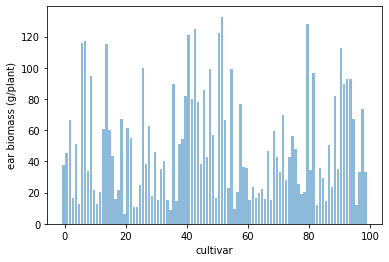

In [15]:
width=0.8
x = np.arange(len(df_sims_cvarmean.dm_ear))
plt.bar(x-width/2, df_sims_cvarmean.dm_ear, width, alpha=0.5)
plt.xlabel('cultivar')
plt.ylabel('ear biomass (g/plant)')

Text(0, 0.5, 'ear biomass (g/plant)')

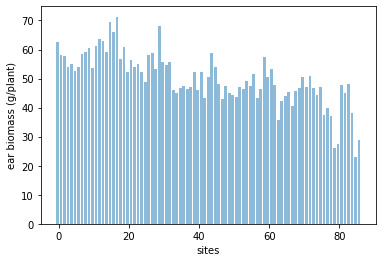

In [16]:
width=0.8
x = np.arange(len(df_sims_sitemean.dm_ear))
plt.bar(x-width/2, df_sims_sitemean.dm_ear, width, alpha=0.5)
plt.xlabel('sites')
plt.ylabel('ear biomass (g/plant)')

### Average yield outcome from all cultivars

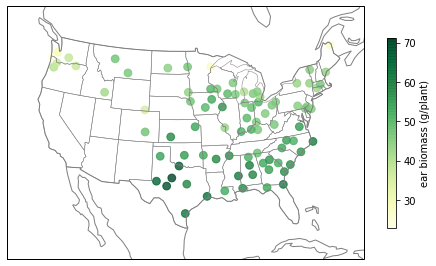

In [171]:
from palettable.colorbrewer.sequential import YlGn_9
sites = df_sites_info[df_sites_info.site.isin(df_sims_sitemean.index)]

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123, -72, 19, 53])
mp = ax.scatter(sites.lon, sites.lat, transform=ccrs.PlateCarree(), 
                s=60, c=df_sims_sitemean.dm_ear, cmap=YlGn_9.mpl_colormap, alpha=0.8)
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
cbar = fig.colorbar(mp, ax=ax, shrink=0.7)
cbar.set_label('ear biomass (g/plant)')

Apparently there are still sites that are having trouble reaching later developmental stages <br/>
-- mostly in Northern locations

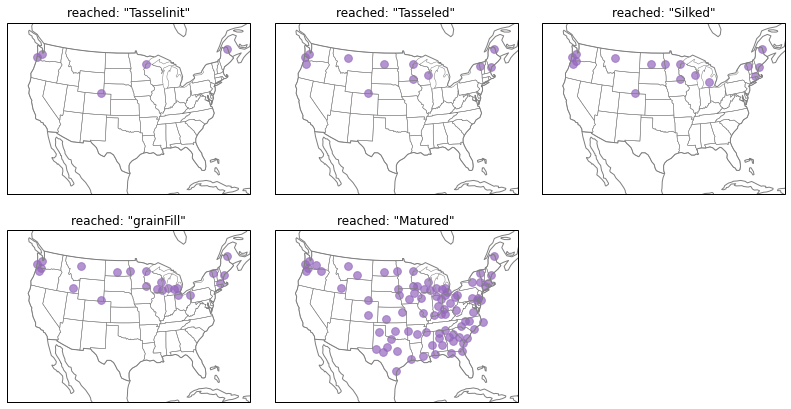

In [20]:
fig = plt.figure(figsize=(12,7))
stages = ['"Tasselinit"', '"Tasseled"', '"Silked"', '"grainFill"', '"Matured"']

for i in np.arange(1,6):
    ax = fig.add_subplot(2,3,i, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    test_sites = set(df_sims[df_sims.note == stages[i-1]].site)
    test_sites_loc = df_sites_info[df_sites_info.site.isin(test_sites)]
    ax.scatter(test_sites_loc.lon, test_sites_loc.lat, transform=ccrs.PlateCarree(), 
                s=60, c='tab:purple', alpha=0.7)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title('reached: ' + stages[i-1])
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.1, hspace=-0.3)

### Full visualization of sim outputs from year 1961

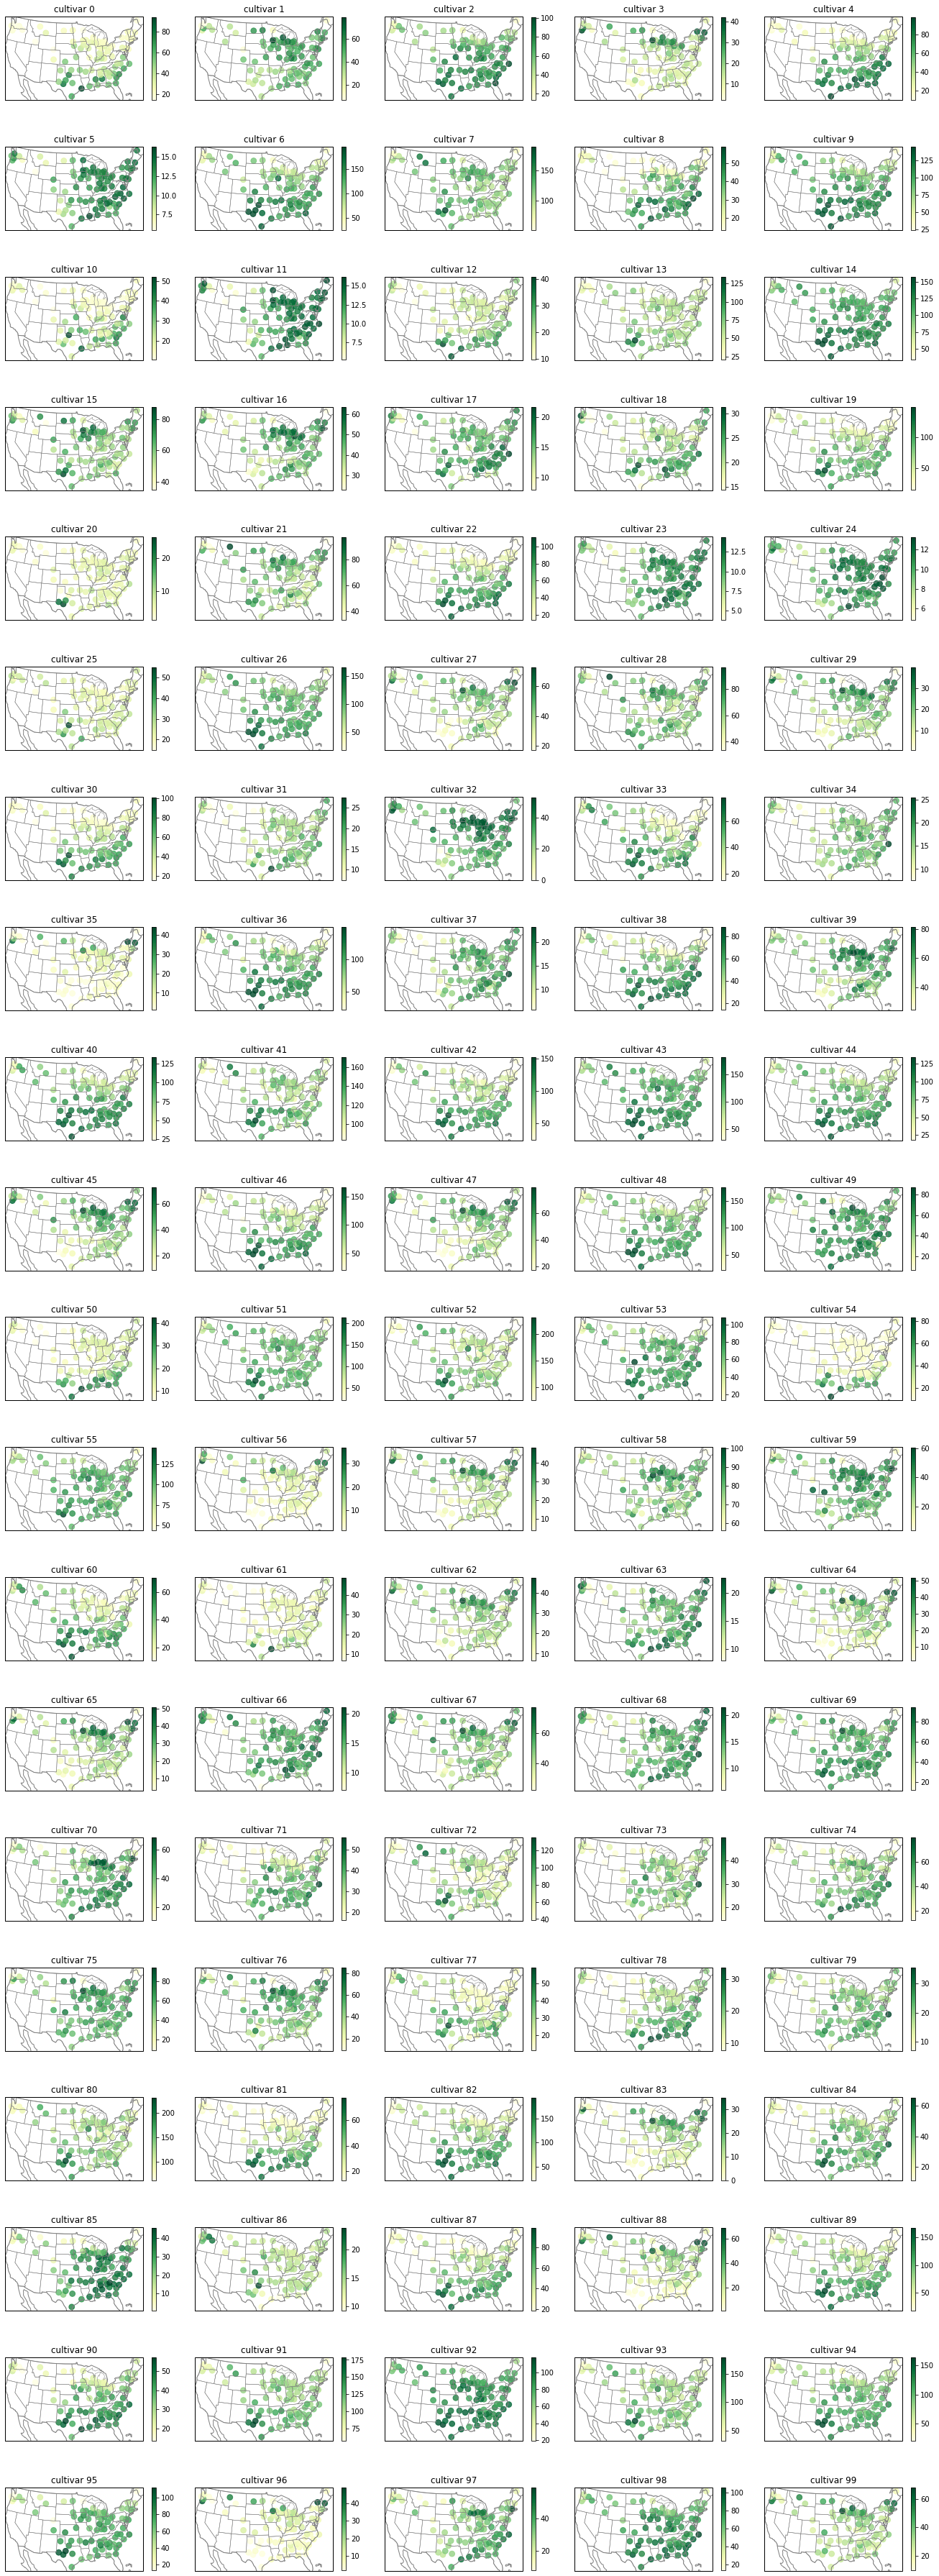

In [35]:
from palettable.colorbrewer.sequential import YlGn_9

cvars = np.arange(0,100)
extent = [-123, -72, 19, 53]

sites = df_sites_info[df_sites_info.site.isin(df_sims_sitemean.index)]

fig, axs = plt.subplots(20, 5, figsize=(20,50), 
                        subplot_kw={'projection': ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35)})

for ax, cvar in zip(axs.flatten(), cvars):
    df_sub = df_sims[df_sims.cvar == cvar]
    mp = ax.scatter(sites.lon, sites.lat, transform=ccrs.PlateCarree(), 
#                   s=60, c=df_sub.dm_ear, cmap=YlGn_9.mpl_colormap, vmin=0, vmax=200, alpha=0.8)
                    s=60, c=df_sub.dm_ear, cmap=YlGn_9.mpl_colormap, alpha=0.8)

    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set(title='cultivar ' + str(cvar))
    cbar = fig.colorbar(mp, ax=ax, shrink=0.7)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.1, hspace=0.1)

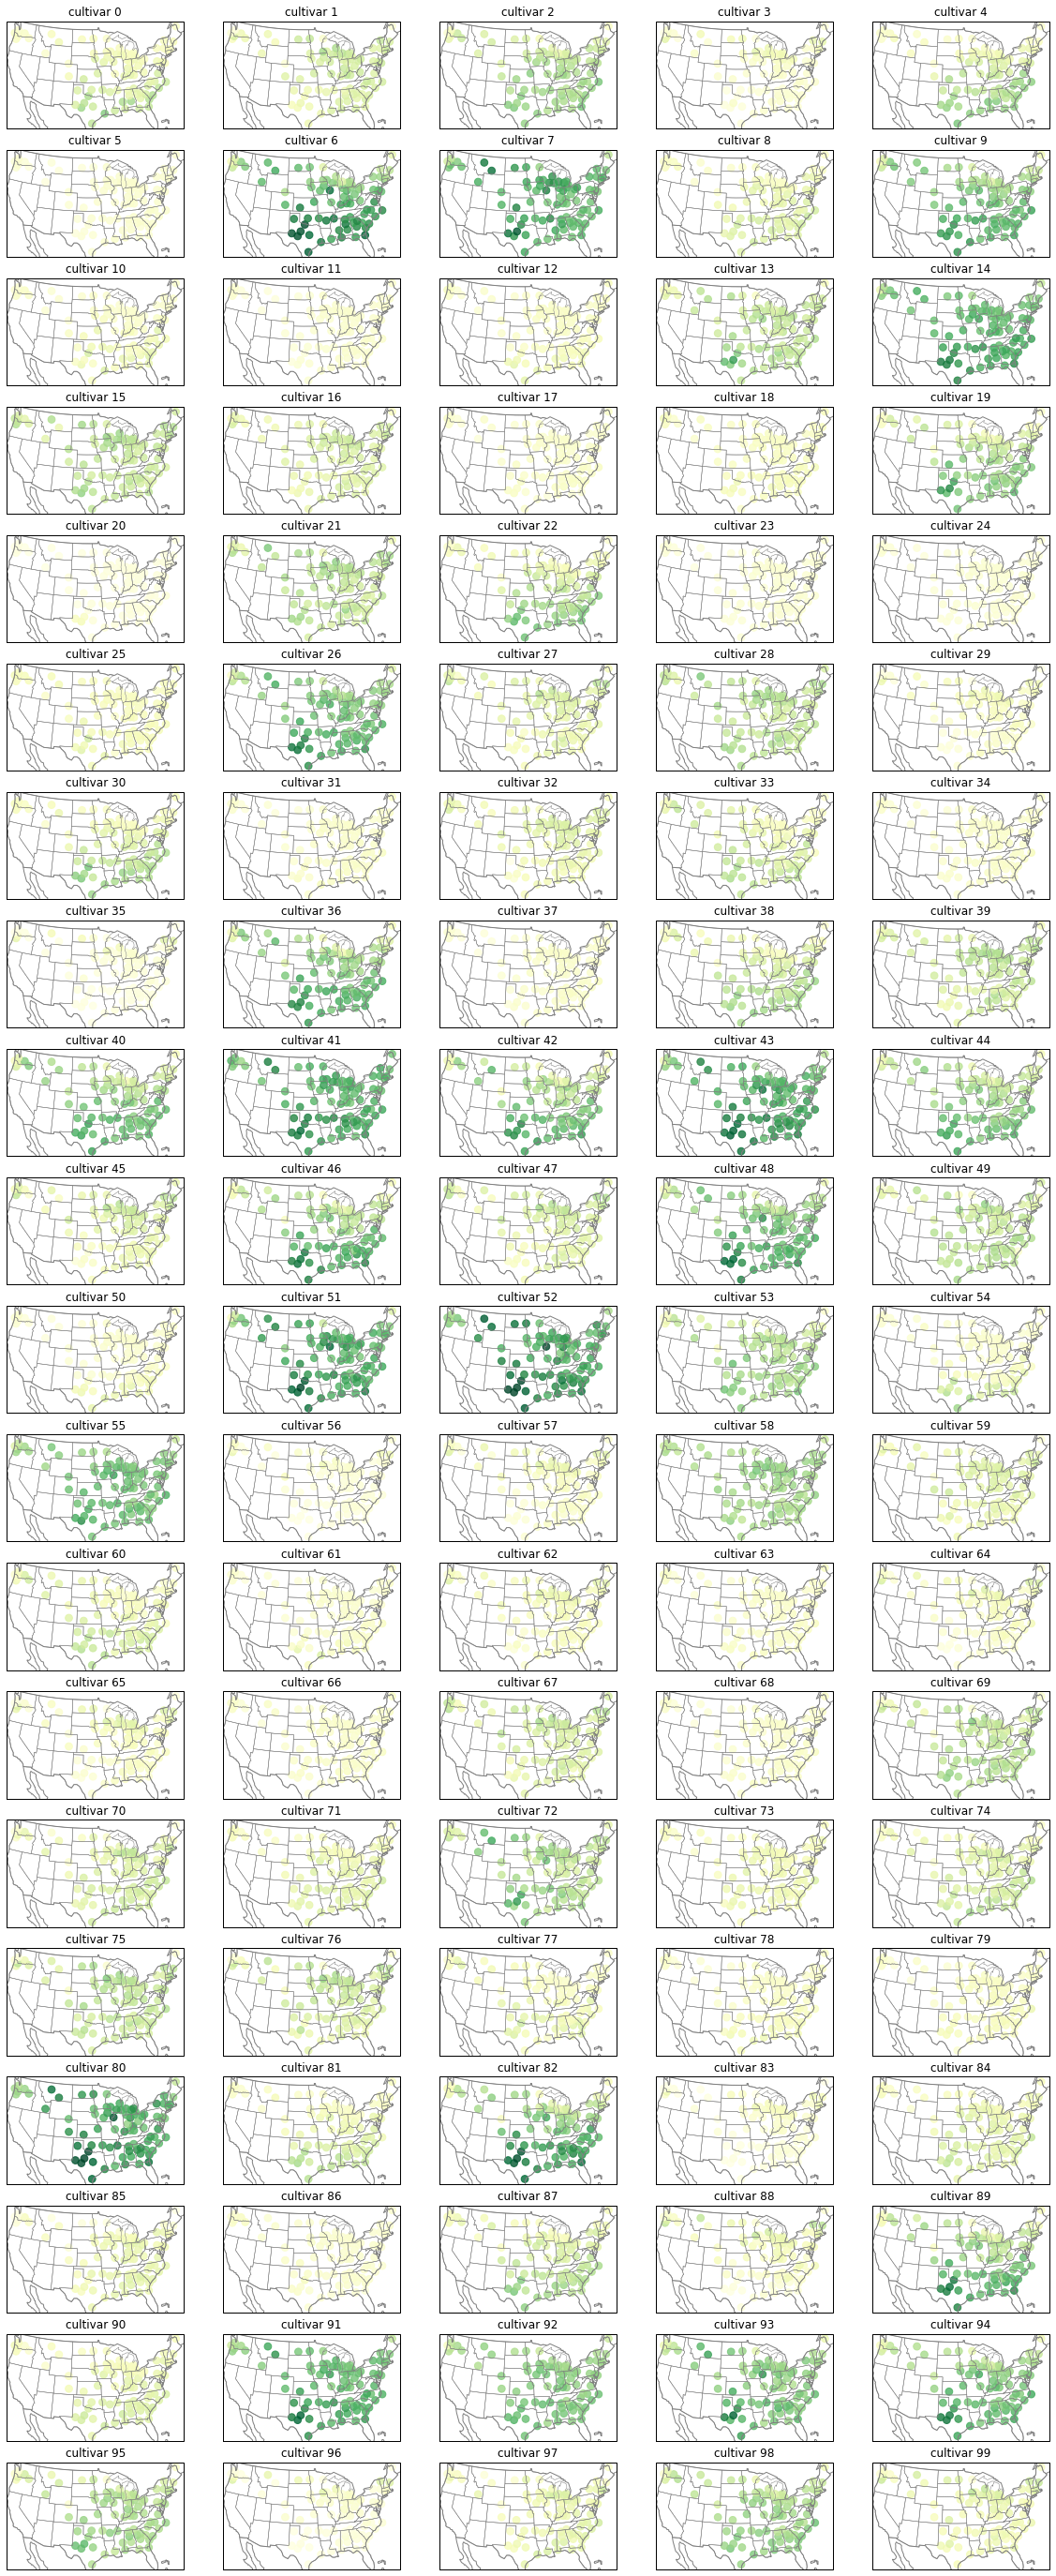

In [165]:
from palettable.colorbrewer.sequential import YlGn_9

cvars = np.arange(0,100)
extent = [-123, -72, 19, 53]

sites = df_sites_info[df_sites_info.site.isin(df_sims_sitemean.index)]

fig, axs = plt.subplots(20, 5, figsize=(20,50), 
                        subplot_kw={'projection': ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35)})

for ax, cvar in zip(axs.flatten(), cvars):
    df_sub = df_sims[df_sims.cvar == cvar]
    ax.scatter(sites.lon, sites.lat, transform=ccrs.PlateCarree(), 
               s=60, c=df_sub.dm_ear, cmap=YlGn_9.mpl_colormap, vmin=0, vmax=200, alpha=0.8)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set(title='cultivar ' + str(cvar))

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/yieldmaps_61.png', format='png', dpi=800, transparent=True)

In [360]:
df_wea = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/wea_summary.csv', index_col=0, dtype={'site': str})
df_wea.head()

site  class                    station state  tzone     lat     lon  \
0  722010      1         KEY WEST INTL ARPT    FL     -5  24.550 -81.750   
1  722020      1              MIAMI INTL AP    FL     -5  25.817 -80.300   
2  722030      1  WEST PALM BEACH INTL ARPT    FL     -5  26.683 -80.100   
3  722050      1          ORLANDO INTL ARPT    FL     -5  28.433 -81.333   
4  722056      1      DAYTONA BEACH INTL AP    FL     -5  29.183 -81.067   

   years       area  perct_irri  
0     25   84670.90   60.802507  
1     29  160227.65   62.002065  
2     19  145225.95   78.435473  
3     19   59312.40   55.098924  
4     19   23625.30   50.088347

In [361]:
df_wea.shape

(213, 10)

In [39]:
df_sims.head()

year  cvar    site        date   jday time leaves mature_lvs drop_lvs  \
0  1961   0.0  722060  07/19/1961  22481    2  23.00         23       18   
1  1961   0.0  722070  07/25/1961  22487   15  23.00         23       19   
2  1961   0.0  722080  07/29/1961  22491    1  23.00         23       18   
3  1961   0.0  722140  07/25/1961  22487   17  24.00         24       20   
4  1961   0.0  722170  07/26/1961  22488   21  24.00         24       20   

       LA  ... dm_ear dm_totleaf dm_dropleaf df_stem df_root roil_rt  \
0  302.09  ...  62.51      26.26       15.98   53.23  33.916  33.897   
1  306.79  ...  69.68      13.87        9.38   21.39  58.106  58.147   
2  308.13  ...  73.07      12.50        7.39   28.05  71.361  71.354   
3  308.71  ...  54.69      17.77       12.03   36.51  59.397  59.380   
4  312.79  ...  40.28      10.32        7.04   19.02  48.128  48.137   

  mx_rootdept available_water soluble_c       note  
0         0.0           0.000      0.11  "Matured"  
1         0.0           0.000      0.08  "Matured"  
2         0.0           0.000      0.26  "Matured"  
3         0.0           0.000      0.08  "Matured"  
4         0.0           0.000      0.12  "Matured"  

[5 rows x 53 columns]

<BarContainer object of 87 artists>

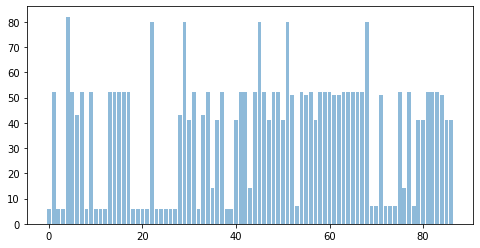

In [150]:
ears = []
cvars_high = []
for i in sites.site:
    df_site = df_sims[df_sims.site == i]
    ear = df_site.dm_ear.max()
    cvar = float(df_site[df_site.dm_ear == df_site.dm_ear.max()].cvar)
    ears.append(ear)
    cvars_high.append(cvar)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
x = list(np.arange(len(cvars)))
ax.bar(x, cvars_high, alpha=0.5)

<BarContainer object of 87 artists>

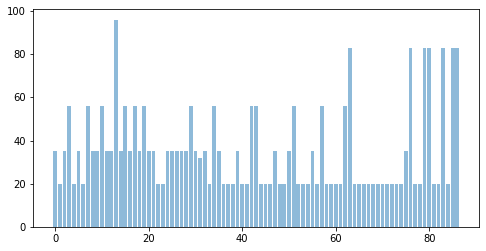

In [151]:
ears = []
cvars_low = []
for i in sites.site:
    df_site = df_sims[df_sims.site == i]
    ear = df_site.dm_ear.max()
    cvar = float(df_site[df_site.dm_ear == df_site.dm_ear.min()].cvar)
    ears.append(ear)
    cvars_low.append(cvar)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
x = list(np.arange(len(cvars)))
ax.bar(x, cvars_low, alpha=0.5)

In [144]:
test = pd.DataFrame(cvars, columns=['cvars'])
test.insert(1, 'count', 1)
test.groupby('cvars').count()

count
cvars       
6.0       19
7.0        7
14.0       3
41.0      10
43.0       3
51.0       6
52.0      33
80.0       5
82.0       1

In [152]:
hyield_vars = list(set(cvars_high))
df_params.iloc[hyield_vars,:]

juv_leaves  stayGreen  rmax_ltir  phyllo  LM_min  Vcmax  Vpmax    g1  \
6           20       4.86       1.35    3.52  116.40  61.87  85.07  3.16   
7           17       6.16       1.02    2.74  119.72  66.05  72.75  6.99   
41          17       3.59       1.28    3.09  103.13  64.23  65.47  4.87   
43          19       3.27       1.32    2.19  112.62  74.30  77.34  7.44   
14          18       6.77       1.38    3.78   85.61  64.07  75.47  6.25   
80          21       5.64       1.27    2.87  115.80  60.05  68.47  9.54   
82          23       5.80       1.38    2.17  119.26  60.67  95.79  6.70   
51          21       6.12       1.26    3.76  115.51  74.76  80.60  7.80   
52          21       7.71       1.41    3.70  110.89  71.05  63.37  7.96   

    ref_potential  rmax_ltar  
6           -2.44       0.68  
7           -1.24       0.51  
41          -1.23       0.64  
43          -1.88       0.66  
14          -1.92       0.69  
80          -2.31       0.64  
82          -3.69       0.69  
51          -1.80       0.63  
52          -1.30       0.71

In [153]:
hyield_vars = list(set(cvars_low))
df_params.iloc[hyield_vars,:]

juv_leaves  stayGreen  rmax_ltir  phyllo  LM_min  Vcmax   Vpmax    g1  \
32          16       3.61       0.52    3.37   86.15  78.39   62.64  5.65   
96          22       6.28       0.57    3.87  103.52  79.57   84.49  1.70   
35          24       6.59       0.61    3.92  112.07  65.13  105.05  4.22   
83          22       3.22       0.54    2.21   93.37  75.28   79.41  3.74   
20          23       3.10       0.64    2.28   88.68  73.99  118.81  9.28   
56          20       7.99       0.56    2.69  105.28  60.92   67.01  9.26   

    ref_potential  rmax_ltar  
32          -2.18       0.26  
96          -2.98       0.29  
35          -2.33       0.30  
83          -1.47       0.27  
20          -3.75       0.32  
56          -3.92       0.28

### Merging datasets

In [587]:
df_sims_m = pd.merge(df_sims, df_params, on='cvar')
df_sims_merged = pd.merge(df_sims_m, sites, on='site')
df_sims_merged.head()

year  cvar    site        date   jday time leaves mature_lvs drop_lvs  \
0  1961   0.0  722060  07/19/1961  22481    2  23.00         23       18   
1  1961   1.0  722060  08/15/1961  22508   13  18.00         18       15   
2  1961   2.0  722060  07/31/1961  22493   15  21.00         21       18   
3  1961   3.0  722060  08/03/1961  22496    6  25.00         25       20   
4  1961   4.0  722060  07/31/1961  22493    8  21.00         21       17   

       LA  ...    g1 ref_potential rmax_ltar class                 station  \
0  302.09  ...  9.86         -3.38      0.62     1  JACKSONVILLE INTL ARPT   
1  160.24  ...  1.37         -2.83      0.28     1  JACKSONVILLE INTL ARPT   
2  188.85  ...  3.88         -2.63      0.50     1  JACKSONVILLE INTL ARPT   
3  354.63  ...  4.86         -3.63      0.34     1  JACKSONVILLE INTL ARPT   
4  329.70  ...  6.31         -3.40      0.41     1  JACKSONVILLE INTL ARPT   

  state tzone   lat   lon years  
0    FL    -5  30.5 -81.7    27  
1    FL    -5  30.5 -81.7    27  
2    FL    -5  30.5 -81.7    27  
3    FL    -5  30.5 -81.7    27  
4    FL    -5  30.5 -81.7    27  

[5 rows x 70 columns]

Text(0.09, 0.5, 'ear biomass (g/plant)')

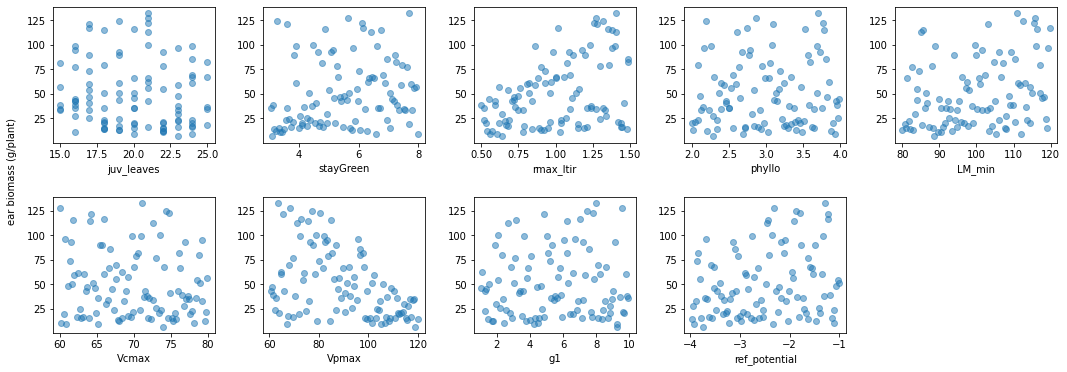

In [191]:
fig = plt.figure(figsize=(18,6))

for i in np.arange(1,10): 
    ax = fig.add_subplot(2,5,i)
    ax.scatter(df_params.iloc[:,i-1], df_sims_cvarmean.dm_ear, alpha=0.5)
    ax.set_xlabel(df_params.columns[i-1])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
fig.text(0.09, 0.5, 'ear biomass (g/plant)', va='center', rotation='vertical')

### Seperating North vs. South

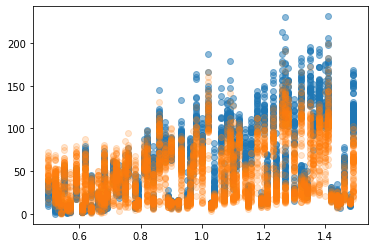

In [610]:
df_sims_south = df_sims_merged[df_sims_merged.lat <= 38]
df_sims_north = df_sims_merged[df_sims_merged.lat > 38]

plt.scatter(df_sims_south.rmax_ltir, df_sims_south.dm_ear, alpha=0.5)
plt.scatter(df_sims_north.rmax_ltir, df_sims_north.dm_ear, alpha=0.2)

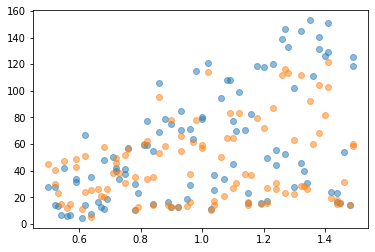

In [633]:
test_south = df_sims_south.groupby('cvar').mean()
test_north = df_sims_north.groupby('cvar').mean()
plt.scatter(test_south.rmax_ltir, test_south.dm_ear, alpha=0.5)
plt.scatter(test_north.rmax_ltir, test_north.dm_ear, alpha=0.5)

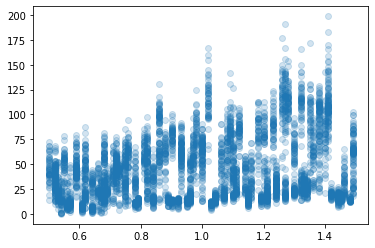

In [611]:
plt.scatter(df_sims_north.rmax_ltir, df_sims_north.dm_ear, alpha=0.2)

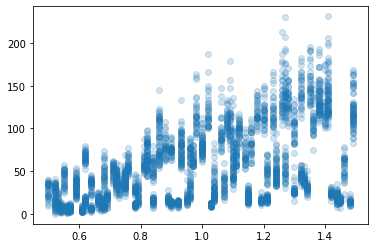

In [613]:
plt.scatter(df_sims_south.rmax_ltir, df_sims_south.dm_ear, alpha=0.2)

### Testing in terms of climate space

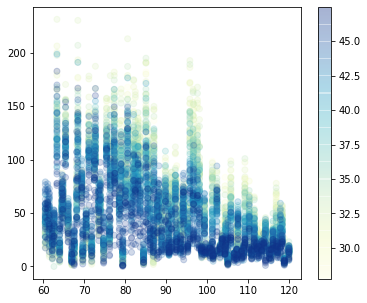

In [583]:
from palettable.colorbrewer.sequential import OrRd_6

fig = plt.figure(figsize=(6,5))
ax = plt.scatter(testt.Vpmax, testt.dm_ear, c=testt.lat, cmap=YlGnBu_8.mpl_colormap, alpha=0.2)
fig.colorbar(ax)

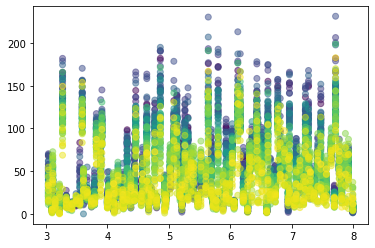

In [570]:
plt.scatter(testt.stayGreen, testt.dm_ear, c=testt.lat, alpha=0.5)

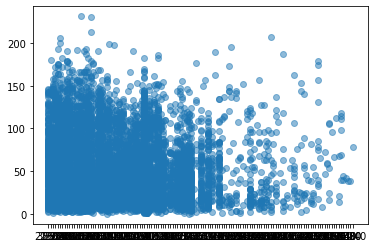

In [617]:
plt.scatter(df_sims.temp_air, df_sims.dm_ear, alpha=0.5)

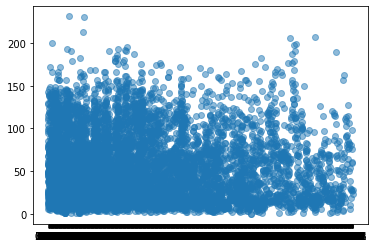

In [620]:
plt.scatter(df_sims.VPD, df_sims.dm_ear, alpha=0.5)

In [619]:
df_sims.columns

Index(['year', 'cvar', 'site', 'date', 'jday', 'time', 'leaves', 'mature_lvs',
       'drop_lvs', 'LA', 'LA_dead', 'LAI', 'RH', 'leaf_WP', 'PFD', 'solrad',
       'temp_soil', 'temp_air', 'temp_can', 'ET_dmd', 'ET_suply', 'Pn', 'Pg',
       'resp', 'av_gs', 'LAI_sunlit', 'LAI_shaded', 'PFD_sunlit', 'PFD_shaded',
       'An_sunlit', 'An_shaded', 'Ag_sunlit', 'Ag_shaded', 'gs_sunlit',
       'gs_shaded', 'VPD', 'N', 'N_dmd', 'N_upt', 'N_leaf', 'PCRL', 'dm_total',
       'dm_shoot', 'dm_ear', 'dm_totleaf', 'dm_dropleaf', 'df_stem', 'df_root',
       'roil_rt', 'mx_rootdept', 'available_water', 'soluble_c', 'note'],
      dtype='object')

In [673]:
sims_61 = df_sims[df_sims.year == '1961']

In [555]:
df_params['cvar'] = list(np.arange(0,100))

In [695]:
df_params = df_params.drop(['rmax_ltar'])

juv_leaves  stayGreen  rmax_ltir  phyllo  LM_min  Vcmax   Vpmax    g1  \
0           23       4.44       1.24    3.31   98.77  77.29   92.57  9.86   
1           16       7.13       0.55    3.98   89.85  67.10   87.81  1.37   
2           21       6.51       1.00    3.04   81.24  66.65   81.56  3.88   
3           24       4.67       0.68    3.24   97.70  69.56   69.67  4.86   
4           20       4.32       0.82    3.13  115.08  64.44  101.27  6.31   
..         ...        ...        ...     ...     ...    ...     ...   ...   
95          25       6.45       1.00    3.34   96.21  70.01   92.25  8.61   
96          22       6.28       0.57    3.87  103.52  79.57   84.49  1.70   
97          17       7.81       0.75    2.92  102.75  72.56  117.85  5.46   
98          17       6.03       0.93    3.19   84.43  61.38   80.06  5.22   
99          23       7.56       0.78    2.23   94.83  68.64   76.20  6.87   

    ref_potential  rmax_ltar  cvar  
0           -3.38       0.62     0  
1           -2.83       0.28     1  
2           -2.63       0.50     2  
3           -3.63       0.34     3  
4           -3.40       0.41     4  
..            ...        ...   ...  
95          -3.52       0.50    95  
96          -2.98       0.29    96  
97          -3.33       0.37    97  
98          -3.87       0.47    98  
99          -2.07       0.39    99  

[100 rows x 11 columns]

In [701]:
df_params_trans

0         1         2         3         4         5   \
juv_leaves  0.800000  0.100000  0.600000  0.900000  0.500000  0.400000   
stayGreen   0.288000  0.826000  0.702000  0.334000  0.264000  0.612000   
rmax_ltir   0.740000  0.050000  0.500000  0.180000  0.320000  0.400000   
phyllo      0.655000  0.990000  0.520000  0.620000  0.565000  0.010000   
LM_min      0.469250  0.246250  0.031000  0.442500  0.877000  0.000750   
Vcmax       0.864500  0.355000  0.332500  0.478000  0.222000  0.403500   
Vpmax       0.542833  0.463500  0.359333  0.161167  0.687833  0.806667   
g1          0.984444  0.041111  0.320000  0.428889  0.590000  0.086667   

                  6         7         8         9   ...        90        91  \
juv_leaves  0.500000  0.200000  0.000000  0.100000  ...  0.500000  0.600000   
stayGreen   0.372000  0.632000  0.904000  0.426000  ...  0.746000  0.686000   
rmax_ltir   0.850000  0.520000  0.600000  0.680000  ...  0.820000  0.910000   
phyllo      0.760000  0.370000  0.820000  0.395000  ...  0.875000  0.305000   
LM_min      0.910000  0.993000  0.323500  0.537000  ...  0.592000  0.125500   
Vcmax       0.093500  0.302500  0.324500  0.961000  ...  0.871000  0.631000   
Vpmax       0.417833  0.212500  0.587667  0.385833  ...  0.971500  0.186000   
g1          0.240000  0.665556  0.691111  0.564444  ...  0.885556  0.185556   

                  92        93        94        95        96        97  \
juv_leaves  0.200000  0.700000  0.400000  1.000000  0.700000  0.200000   
stayGreen   0.164000  0.416000  0.328000  0.690000  0.656000  0.962000   
rmax_ltir   0.620000  0.590000  0.480000  0.500000  0.070000  0.250000   
phyllo      0.385000  0.865000  0.335000  0.670000  0.935000  0.460000   
LM_min      0.349250  0.653250  0.732000  0.405250  0.588000  0.568750   
Vcmax       0.270500  0.845500  0.076000  0.500500  0.978500  0.628000   
Vpmax       0.291667  0.273167  0.374833  0.537500  0.408167  0.964167   
g1          0.096667  0.688889  0.901111  0.845556  0.077778  0.495556   

                  98        99  
juv_leaves  0.200000  0.800000  
stayGreen   0.606000  0.912000  
rmax_ltir   0.430000  0.280000  
phyllo      0.595000  0.115000  
LM_min      0.110750  0.370750  
Vcmax       0.069000  0.432000  
Vpmax       0.334333  0.270000  
g1          0.468889  0.652222  

[8 rows x 100 columns]

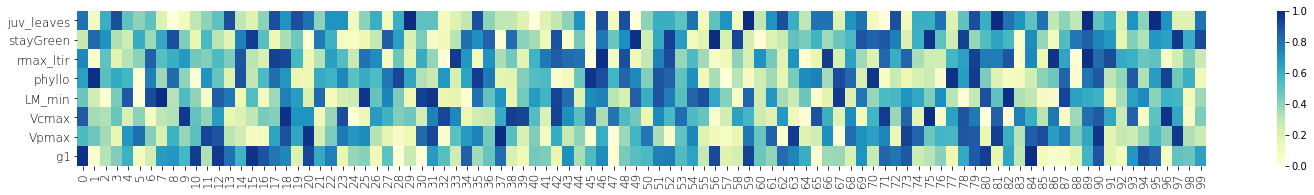

In [721]:
# setting parameter range

df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params = df_params.drop(['rmax_ltar'], axis=1)

param_range = {'juv_leaves': [15, 25],
               'stayGreen': [3,8],
               'rmax_ltir': [0.5, 1.5],
               'phyllo': [2, 4],
               'LM_min': [80, 120],
               'Vcmax': [60, 80],
               'Vpmax': [60, 120],
               'g1': [1, 10], 
               'ref_potential': [-4, -1]}

params = df_params.columns[:-1]
df_params_fold = pd.DataFrame(columns=params)
for i in params: 
    df_params_fold[i] = fold(df_params[i], param_range[i][0], param_range[i][1])
df_params_trans = pd.DataFrame(df_params_fold.transpose())

fig, ax = plt.subplots(figsize=(28,5))
ax = sns.heatmap(df_params_trans, cmap=YlGnBu_8.mpl_colormap)

plt.xticks(fontweight='light', fontsize=12)
plt.yticks(rotation=0, fontweight='light', fontsize=12)

# adjusting color bar specifics
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
#fig.colorbar(ax, cax=cbar)

fig.subplots_adjust(left=0.2, bottom=0.45)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/params_100.png', format='png', dpi=800, transparent=True)

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

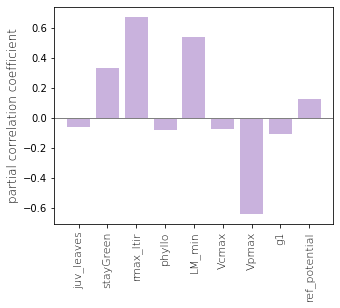

In [359]:
# setting up parameter values and ear biomass
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params = df_params.drop(['rmax_ltar'], axis=1)
df_params = pd.concat([df_params, pd.Series(df_sims.groupby('cvar').mean().dm_ear)], axis=1)

# calculate partial correlation coefficient
from partial_corr import partial_corr
output = partial_corr(df_params)
output[-1]

# plotting
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
params = list(df_params.columns[:-1])
corrs = output[-1][:-1]
ax.bar(params, corrs, alpha=0.5, color='tab:purple')
ax.set_ylabel('partial correlation coefficient', fontsize=12, weight='light')
ax.axhline(0, color='grey', lw=1)
plt.xticks(rotation=90, fontsize=11, weight='light')

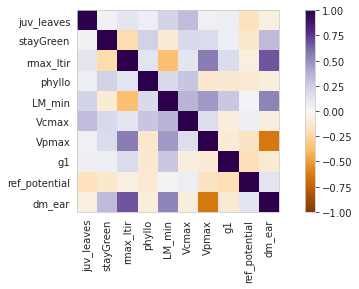

In [260]:
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params = df_params.drop(['rmax_ltar'], axis=1)

param_range = {'juv_leaves': [15, 25],
               'stayGreen': [3,8],
               'rmax_ltir': [0.5, 1.5],
               'phyllo': [2, 4],
               'LM_min': [80, 120],
               'Vcmax': [60, 80],
               'Vpmax': [60, 120],
               'g1': [1, 10], 
               'ref_potential': [-4, -1]}

params = df_params.columns
df_params_fold = pd.DataFrame(columns=params)
for i in params: 
    df_params_fold[i] = fold(df_params[i], param_range[i][0], param_range[i][1])

test = pd.concat([df_params, pd.Series(df_sims.groupby('cvar').mean().dm_ear)], axis=1)

    
from partial_corr import partial_corr
output = partial_corr(test)

params = test.columns

with sns.axes_style('whitegrid'): # adding this line just makes the figure look a bit nicer
    
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(output, cmap='PuOr', vmin=-1, vmax=1)
    ax.set_xticks(np.arange(0,10))
    ax.set_xticklabels(params, rotation=90)
    ax.set_yticks(np.arange(0,10))
    ax.set_yticklabels(params, rotation=0)

    ax.grid(False)
    plt.colorbar(im)
    fig.subplots_adjust(left=-0.5, bottom=0.25, right=0.95, top=0.95)

In [303]:
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params = df_params.drop(['rmax_ltar'], axis=1)

param_range = {'juv_leaves': [15, 25],
               'stayGreen': [3,8],
               'rmax_ltir': [0.5, 1.5],
               'phyllo': [2, 4],
               'LM_min': [80, 120],
               'Vcmax': [60, 80],
               'Vpmax': [60, 120],
               'g1': [1, 10], 
               'ref_potential': [-4, -1]}

params = df_params.columns
df_params_fold = pd.DataFrame(columns=params)
for i in params: 
    df_params_fold[i] = fold(df_params[i], param_range[i][0], param_range[i][1])

test = pd.concat([df_params_fold, pd.Series(df_sims.groupby('cvar').mean().dm_ear)], axis=1)

test.partial_corr(x='dm_ear', y='rmax_ltir',
                  covar=['juv_leaves', 'stayGreen', 'phyllo', 'LM_min', 'Vcmax', 'Vpmax', 'g1', 'ref_potential'])

n         r         CI95%        r2    adj_r2         p-val  \
pearson  100  0.674247  [0.55, 0.77]  0.454609  0.443364  1.479185e-14   

              BF10  power  
pearson  5.544e+11    1.0

#### *Note when converting from dm_ear to yield:
1. Planting density 
2. Shelling percentage (grain weight/ear weight)
    - scaler that converts ear mass to actual grain yield
    - 0.86 is the scale value used in previous paper but need to find citation to back it
    - Looking around seems like 0.8 is a common value people use when corn is harvested at ~20-25% grain moisture
    - Haven't really found a good citation yet, but here are a few links to start with: 
        - Tandzi and Mutengwa, 2020, Agronomy
        - Masuka et al., 2017, Crop Science (80% shelling percentage and 12.5% grain moisture)
        - Horrocks and Zuber, 1970

### Including weather information

In [363]:
# reading in weather data
df_temp = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/temp_all.csv', index_col= 0)
df_rh = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/rh_all.csv', index_col= 0)
df_precip = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/precip_all.csv', index_col= 0)
df_solrad = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/solrad_all.csv', index_col= 0)

# interpolating weather data 
df_temp = df_temp.interpolate()
df_rh = df_rh.interpolate()
df_precip = df_precip.interpolate()
df_solrad = df_solrad.interpolate()

In [364]:
# filtering sites based on planting area & irrigation
siteyear_ctr2 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr2.csv', 
                            usecols=[1,2], dtype='str') 
df_summary = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/wea_summary.csv', 
                         index_col=0, dtype={'site': str})
df_filtered = df_summary[(df_summary.area > 1000) & (df_summary.perct_irri < 50)]
siteyears = siteyear_ctr2[siteyear_ctr2.site.isin(df_filtered.site)] # df_filtered accounts for irrigation & planting area
                                                                     # and has AK, GU, HI, & PR removed already

In [366]:
def CC_VPD(temp, rh):
    """
    function that calculates VPD with temperature and RH
    RH values range between 0 & 1 (fraction, not %)
    """
    # constant parameters
    Tref = 273.15  # reference temperature
#    Es_Tref = 6.11 # saturation vapor pressure at reference temperature (mb)
    Es_Tref = 0.611 # saturation vapor pressure at reference temperature (kPa)
    Lv = 2.5e+06   # latent heat of vaporation (J/kg)
    Rv = 461       # gas constant for moist air (J/kg)
    
    # transformed temperature inputs
    Tair = temp + Tref
    
    # Clausius-Clapeyron relation
    es = Es_Tref*np.exp((Lv/Rv)*(1/Tref - 1/Tair))
    e = es*rh
    vpd = es-e
    
    return(vpd)

In [367]:
# converting the dataframe-style weather data into a single long-form list
# - only selecting weather data for filtered siteyears
# - plotting data for growing season between 4/1 - 10/31
temp_all = [np.nan]*siteyears.shape[0]
rh_all = [np.nan]*siteyears.shape[0]
precip_all = [np.nan]*siteyears.shape[0]
solrad_all = [np.nan]*siteyears.shape[0]

for i in np.arange(siteyears.shape[0]):
    # growing season temp mean for each site-year
    temp = df_temp.loc[siteyears.iloc[i,1] + '-04-01' : 
                       siteyears.iloc[i,1] +'-10-31', 
                       siteyears.iloc[i,0]].mean()
    # growing season RH mean for each site-year
    rh = df_rh.loc[siteyears.iloc[i,1] + '-04-01' : 
                   siteyears.iloc[i,1] +'-10-31', 
                   siteyears.iloc[i,0]].mean()
    # growing season precip sum for each site-year
    precip = df_precip.loc[siteyears.iloc[i,1] + '-04-01' : 
                           siteyears.iloc[i,1] +'-10-31', 
                           siteyears.iloc[i,0]].sum()

    # 
    solrad = df_solrad.loc[siteyears.iloc[i,1] + '-04-01' : 
                           siteyears.iloc[i,1] +'-10-31', 
                           siteyears.iloc[i,0]].mean()
    
    
    temp_all[i] = temp
    rh_all[i] = rh
    precip_all[i] = precip
    solrad_all[i] = solrad
    
# calculating VPD based on temperature & RH
vpd_all = []
for i in np.arange(len(temp_all)):
    vpd_all.append(CC_VPD(temp_all[i], rh_all[i]/100))
    
# storing output in dataframe
df_siteyears_weamean = siteyears.copy()
df_siteyears_weamean['temp'] = list(temp_all)
df_siteyears_weamean['rh'] = list(rh_all)
df_siteyears_weamean['precip'] = list(precip_all)
df_siteyears_weamean['solrad'] = list(solrad_all)
df_siteyears_weamean['vpd'] = list(vpd_all)
df_siteyears_weamean = pd.merge(df_siteyears_weamean, df_filtered, on='site')

In [370]:
df_year = df_siteyears_weamean[df_siteyears_weamean.year=='1961']
df_year.head()

site  year       temp         rh  precip      solrad       vpd  class  \
0    722060  1961  23.875626  73.319667   711.7  224.052621  0.804103      1   
27   722070  1961  22.527191  74.713304   881.8  234.060642  0.701216      1   
49   722080  1961  21.895951  77.313629   899.4  232.128717  0.604899      1   
82   722140  1961  22.738077  75.005814   735.9  229.369523  0.702224      1   
101  722170  1961  22.185094  68.543369   605.2  230.181534  0.853975      1   

                            station state  tzone     lat     lon  years  \
0            JACKSONVILLE INTL ARPT    FL     -5  30.500 -81.700     27   
27                 SAVANNAH INTL AP    GA     -5  32.117 -81.200     22   
49             CHARLESTON INTL ARPT    SC     -5  32.900 -80.033     25   
82   TALLAHASSEE REGIONAL AP [ISIS]    FL     -5  30.400 -84.350     19   
101     MACON MIDDLE GA REGIONAL AP    GA     -5  32.683 -83.650     22   

        area  perct_irri  
0     4978.0   10.089223  
27    8108.6    6.585904  
49   41559.4    5.152189  
82   24496.7   13.348148  
101  19022.8   18.039572

Text(0, 0.5, 'VPD')

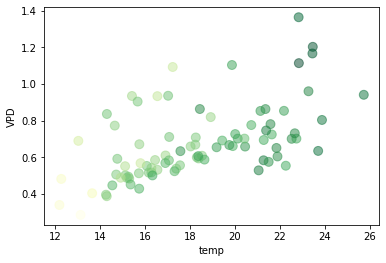

In [563]:
plt.scatter(df_year.temp, df_year.vpd, c=df_sims.groupby('site').mean().dm_ear, 
            cmap=YlGn_9.mpl_colormap, alpha=0.5, s=80)
plt.xlabel('temp')
plt.ylabel('VPD')

In [498]:
temp_threshold = 18
vpd_threshold = 0.7

df_hthv = df_year[(df_year.temp>temp_threshold) & (df_year.vpd>vpd_threshold)]
df_htlv = df_year[(df_year.temp>temp_threshold) & (df_year.vpd<vpd_threshold)]
df_lthv = df_year[(df_year.temp<temp_threshold) & (df_year.vpd>vpd_threshold)]
df_ltlv = df_year[(df_year.temp<temp_threshold) & (df_year.vpd<vpd_threshold)]

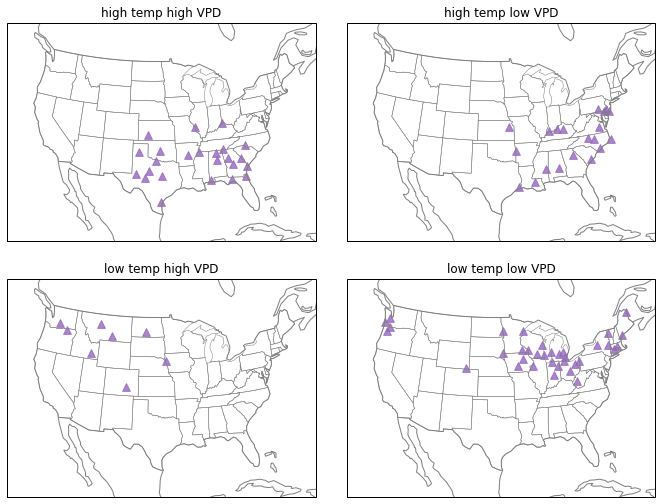

In [529]:
fig = plt.figure(figsize=(10,8))

dframes = [df_hthv, df_htlv, df_lthv, df_ltlv]
titles = ['high temp high VPD', 'high temp low VPD',
          'low temp high VPD', 'low temp low VPD']

for i in np.arange(4):
    ax = fig.add_subplot(2,2,i+1, projection=ccrs.AlbersEqualArea(
                         central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])

    mp = ax.scatter(dframes[i].lon, dframes[i].lat, transform=ccrs.PlateCarree(), 
                    s=60, marker='^', c='tab:purple', alpha=0.8)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(titles[i])
#    cbar = fig.colorbar(mp, shrink=0.4)

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.1, hspace=-0.2)

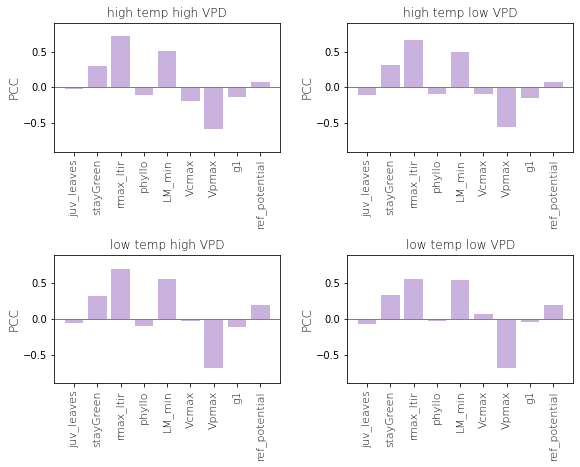

In [506]:
# setting up parameter values and ear biomass
dframes = [df_hthv, df_htlv, df_lthv, df_ltlv]
titles = ['high temp high VPD', 'high temp low VPD', 
          'low temp high VPD', 'low temp low VPD']

fig = plt.figure(figsize=(8,5))

for i in np.arange(4):
    df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
    df_params = df_params.drop(['rmax_ltar'], axis=1)
    df_sims_sub = pd.Series(df_sims[df_sims.site.isin(list(dframes[i].site))].groupby('cvar').mean().dm_ear)
    df_params = pd.concat([df_params, df_sims_sub], axis=1)

    # calculate partial correlation coefficient
    from partial_corr import partial_corr
    output = partial_corr(df_params)

    # plotting
    ax = fig.add_subplot(2,2,i+1)
    params = list(df_params.columns[:-1])
    corrs = output[-1][:-1]
    ax.bar(params, corrs, alpha=0.5, color='tab:purple')
    ax.set_ylim([-0.9, 0.9])
    ax.set_ylabel('PCC', fontsize=12, weight='light')
    ax.axhline(0, color='grey', lw=1)
    plt.xticks(rotation=90, fontsize=11, weight='light')    
    plt.title(titles[i], weight='light')

fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.3, hspace=0.8)

In [537]:
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params = df_params.drop(['rmax_ltar'], axis=1)
df_sims_sub = pd.Series(df_sims[df_sims.site.isin(list(df_ltlv.site))].groupby('cvar').mean().dm_ear)
df_params = pd.concat([df_params, df_sims_sub], axis=1)

df_params.partial_corr(x='dm_ear', y= 'ref_potential',
                       covar=['rmax_ltir', 'g1', 'stayGreen','phyllo', 'LM_min', 'Vcmax', 'Vpmax', 'juv_leaves'])

n         r        CI95%        r2    adj_r2    p-val   BF10  \
pearson  100  0.197674  [0.0, 0.38]  0.039075  0.019262  0.04868  0.848   

           power  
pearson  0.50855